In [1]:
import os
import umap
import torch
import itertools
from core import *
import numpy as np
import pandas as pd
import pickle as pkl
from torch import nn
import os.path as op
from tqdm import tqdm
from time import time
from Bio import SeqIO
from copy import deepcopy
from torch.optim import Adam
from tpot import TPOTRegressor
import torch.nn.functional as F
import matplotlib.pyplot as plt
from capsules.capsules import *
from IPython.display import Image
from qhoptim.pyt import QHM, QHAdam
from matplotlib.lines import Line2D
from torch.autograd import Variable
from matplotlib.patches import Patch
from scipy.stats import spearmanr, pearsonr
from catboost import CatBoostRegressor, Pool, cv
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error
from sklearn.metrics import accuracy_score, matthews_corrcoef, precision_score, recall_score

/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)
/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: F

In [2]:
len("TTTCTGAGCATCCCGGGGATCCC")

23

In [3]:
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset

In [4]:
import gpytorch
from gpytorch.means import ConstantMean, LinearMean
from gpytorch.models import ApproximateGP, ExactGP 
from sklearn.metrics import accuracy_score
from gpytorch.priors import SmoothedBoxPrior
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.kernels import ScaleKernel, RBFKernel, GridInterpolationKernel
from gpytorch.mlls import VariationalELBO, VariationalELBOEmpirical, DeepApproximateMLL
from gpytorch.distributions import MultivariateNormal
from gpytorch.variational import CholeskyVariationalDistribution
from gpytorch.variational import VariationalStrategy
from gpytorch.models.deep_gps import DeepGPLayer, DeepGP

In [5]:
np.random.seed(1341)
torch.manual_seed(1341)

In [6]:
DATAPATH = "/home/bakirillov/HDD/data/genomes/all_guides_chr22.tsv"
ANNOTATION = "/home/bakirillov/HDD/data/genomes/annotation.csv"

In [7]:
annotation = pd.read_csv(ANNOTATION, header=1)[["Start", "Stop", "Gene symbol"]]
annotation = list(
    zip(
        annotation["Start"].values, annotation["Stop"].values, 
        annotation["Gene symbol"].values
    )
)
annotation = sorted(annotation, key=lambda x: x[0])

In [8]:
transformer = get_Cas9_transformer(True)

In [9]:
chr22 = SeqIO.parse("/home/bakirillov/HDD/data/genomes/chr22.fa", "fasta")
chr22 = [a for a in chr22][0]

In [10]:
TEMPLATE = "/home/bakirillov/HDD/data/chr22_genes/GENE\nNNNNNNNNNNNNNNNNNNNNNGG\nNNNNNNNNNNNNNNNNNNNNNGG 0\n"
COMMAND = "/home/bakirillov/HDD/apps/cas-offinder CONFIG G OUTPUT"

In [11]:
if not op.exists("/home/bakirillov/HDD/data/chr22_genes/"):
    os.makedirs("/home/bakirillov/HDD/data/chr22_genes/")
if not op.exists("/home/bakirillov/HDD/data/chr22_grnas/"):
    os.makedirs("/home/bakirillov/HDD/data/chr22_grnas/")
if not op.exists("/home/bakirillov/HDD/data/chr22_casoffinder_configs/"):
    os.makedirs("/home/bakirillov/HDD/data/chr22_casoffinder_configs/")

In [12]:
script = open("run_casoffinder.sh", "w")
script.write("#!/bin/sh\n\n")
for start, stop, gene in tqdm(annotation):
    with open("/home/bakirillov/HDD/data/chr22_genes/"+gene+".fa", "w") as oh:
        oh.write(">"+gene+"\n")
        oh.write(str(chr22.seq[start:stop]))
    with open("/home/bakirillov/HDD/data/chr22_casoffinder_configs/"+gene+".txt", "w") as oh:
        oh.write(TEMPLATE.replace("GENE", gene+".fa"))
    script.write(
        COMMAND.replace(
            "CONFIG", "/home/bakirillov/HDD/data/chr22_casoffinder_configs/"+gene+".txt"
        ).replace(
            "OUTPUT", "/home/bakirillov/HDD/data/chr22_grnas/"+gene+".tsv"
        )+"\n"
    )
script.close()

100%|██████████| 1186/1186 [00:00<00:00, 1787.78it/s]


In [13]:
cnn_mse_encoder = GuideHN(21, 32, 1360, n_classes=5).cuda()
cnn_mse = DKL(cnn_mse_encoder, [1,5*32]).cuda()
cnn_mse.load_state_dict(torch.load("../models/DeepHF/Wt/cnn_mse59.ptch"))
cnn_mse = cnn_mse.eval()

In [14]:
rnn_mse_encoder = GuideHRNN(21, 32, 3360, n_classes=5).cuda()
rnn_mse = DKL(rnn_mse_encoder, [1,5*32]).cuda()
rnn_mse.load_state_dict(torch.load("../models/DeepHF/Wt/rnn_mse59.ptch"))
rnn_mse = rnn_mse.eval()

In [15]:
cnn_elbo_encoder = GuideHN(21, 32, 1360, n_classes=5).cuda()
cnn_elbo = DKL(cnn_elbo_encoder, [1,5*32]).cuda()
cnn_elbo.load_state_dict(torch.load("../models/DeepHF/Wt/cnn_elbo59.ptch"))
cnn_elbo = cnn_elbo.eval()

In [16]:
rnn_elbo_encoder = GuideHRNN(21, 32, 3360, n_classes=5).cuda()
rnn_elbo = DKL(rnn_elbo_encoder, [1,5*32]).cuda()
rnn_elbo.load_state_dict(torch.load("../models/DeepHF/Wt/rnn_elbo59.ptch"))
rnn_elbo = rnn_elbo.eval()

In [17]:
data = np.array(
    [a for a in os.walk("/home/bakirillov/HDD/data/chr22_grnas/")][0][2]
)

In [18]:
sizes = np.array(
    [op.getsize(op.join("/home/bakirillov/HDD/data/chr22_grnas", a)) for a in data]
)

In [19]:
current_df = pd.read_csv(
    op.join(
        "/home/bakirillov/HDD/data/chr22_grnas/LOC440792.tsv"
    ), sep="\t", header=None
).dropna()
current_df = current_df[current_df[3].apply(lambda x: len(x) == 23)]
tds = DeepHFDataset(
    current_df, np.arange(current_df.shape[0]), transformer, sequence_column=3, 
    label_column=5
)
tld = DataLoader(tds, shuffle=False, batch_size=256)
tb_cnn_mse_oa = []
tb_cnn_mse_va = []
tb_cnn_mse_ra = []
tb_rnn_mse_oa = []
tb_rnn_mse_va = []
tb_rnn_mse_ra = []
tb_cnn_elbo_oa = []
tb_cnn_elbo_va = []
tb_cnn_elbo_ra = []
tb_rnn_elbo_oa = []
tb_rnn_elbo_va = []
tb_rnn_elbo_ra = []
for transformed_batch, _ in tqdm(tld):
    tb_cnn_mse_o = cnn_mse_encoder(transformed_batch)[0].cpu().data.numpy()
    tb_cnn_mse_ra.extend(tb_cnn_mse_o)
    tb_rnn_mse_o = rnn_mse_encoder(transformed_batch)[0].cpu().data.numpy()
    tb_rnn_mse_ra.extend(tb_rnn_mse_o)
    tb_cnn_elbo_o = cnn_elbo_encoder(transformed_batch)[0].cpu().data.numpy()
    tb_cnn_elbo_ra.extend(tb_cnn_elbo_o)
    tb_rnn_elbo_o = rnn_elbo_encoder(transformed_batch)[0].cpu().data.numpy()
    tb_rnn_elbo_ra.extend(tb_rnn_elbo_o)
    tb_cnn_mse = cnn_mse(transformed_batch)
    tb_cnn_mse_o = cnn_mse.likelihood(
        tb_cnn_mse[0]
    ).mean.mean(0).cpu().data.numpy()
    tb_cnn_mse_v = cnn_mse.likelihood(
        tb_cnn_mse[0]
    ).variance.mean(0).cpu().data.numpy()
    tb_cnn_mse_oa.extend(tb_cnn_mse_o)
    tb_cnn_mse_va.extend(tb_cnn_mse_v)
    tb_rnn_mse = rnn_mse(transformed_batch)
    tb_rnn_mse_o = rnn_mse.likelihood(
        tb_rnn_mse[0]
    ).mean.mean(0).cpu().data.numpy()
    tb_rnn_mse_v = rnn_mse.likelihood(
        tb_rnn_mse[0]
    ).variance.mean(0).cpu().data.numpy()
    tb_rnn_mse_oa.extend(tb_rnn_mse_o)
    tb_rnn_mse_va.extend(tb_rnn_mse_v)
    tb_cnn_elbo = cnn_elbo(transformed_batch)
    tb_cnn_elbo_o = cnn_elbo.likelihood(
        tb_cnn_elbo[0]
    ).mean.mean(0).cpu().data.numpy()
    tb_cnn_elbo_v = cnn_elbo.likelihood(
        tb_cnn_elbo[0]
    ).variance.mean(0).cpu().data.numpy()
    tb_cnn_elbo_oa.extend(tb_cnn_elbo_o)
    tb_cnn_elbo_va.extend(tb_cnn_elbo_v)
    tb_rnn_elbo = rnn_elbo(transformed_batch)
    tb_rnn_elbo_o = rnn_elbo.likelihood(
        tb_rnn_elbo[0]
    ).mean.mean(0).cpu().data.numpy()
    tb_rnn_elbo_v = rnn_elbo.likelihood(
        tb_rnn_elbo[0]
    ).variance.mean(0).cpu().data.numpy()
    tb_rnn_elbo_oa.extend(tb_rnn_elbo_o)
    tb_rnn_elbo_va.extend(tb_rnn_elbo_v)

100%|██████████| 11/11 [00:01<00:00,  5.87it/s]


In [20]:
tb_cnn_mse_ra = np.stack(tb_cnn_mse_ra).reshape(-1, 5*32)
tb_rnn_mse_ra = np.stack(tb_rnn_mse_ra).reshape(-1, 5*32)
tb_cnn_elbo_ra = np.stack(tb_cnn_elbo_ra).reshape(-1, 5*32)
tb_rnn_elbo_ra = np.stack(tb_rnn_elbo_ra).reshape(-1, 5*32)

In [21]:
uvis_cm = umap.UMAP(random_state=1341)
uvis_cm.fit(tb_cnn_mse_ra)

UMAP(a=None, angular_rp_forest=False, b=None, init='spectral',
     learning_rate=1.0, local_connectivity=1.0, metric='euclidean',
     metric_kwds=None, min_dist=0.1, n_components=2, n_epochs=None,
     n_neighbors=15, negative_sample_rate=5, random_state=1341,
     repulsion_strength=1.0, set_op_mix_ratio=1.0, spread=1.0,
     target_metric='categorical', target_metric_kwds=None,
     target_n_neighbors=-1, target_weight=0.5, transform_queue_size=4.0,
     transform_seed=42, verbose=False)

In [1]:
23445*1200

28134000

In [22]:
from sklearn.decomposition import PCA

In [23]:
pvis_cm = PCA(random_state=1341)
pv_cm = pvis_cm.fit_transform(tb_cnn_mse_ra)

In [24]:
import ncvis

In [25]:
nvis_cm = ncvis.NCVis(random_seed=1341)
nv_cm = nvis_cm.fit_transform(tb_cnn_mse_ra)

In [26]:
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram

In [27]:
np.random.seed(12314)
ln = linkage(nv_cm, "average")

In [28]:
ln

array([[9.50000000e+02, 2.16400000e+03, 7.41040528e-03, 2.00000000e+00],
       [4.24000000e+02, 2.76300000e+03, 1.06577591e-02, 2.00000000e+00],
       [7.56000000e+02, 2.72500000e+03, 1.67692315e-02, 2.00000000e+00],
       ...,
       [5.53100000e+03, 5.55600000e+03, 1.83998966e+01, 8.57000000e+02],
       [5.55500000e+03, 5.55700000e+03, 1.85918543e+01, 1.92400000e+03],
       [5.55800000e+03, 5.55900000e+03, 2.61781073e+01, 2.78100000e+03]])

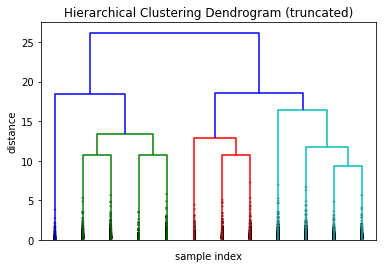

In [29]:
plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    ln,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=12,  # show only the last p merged clusters
    show_leaf_counts=False,  # otherwise numbers in brackets are counts
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.show()



In [30]:
max_d = 2

In [31]:
clusters = fcluster(ln, max_d, criterion='distance')

In [32]:
np.unique(clusters, return_counts = True)

(array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
         27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
         40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
         53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
         66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
         79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
         92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
        105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
        118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
        131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
        144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
        157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
        170, 171, 172, 173, 174, 175, 176, 177, 178

In [33]:
np.unique(clusters).shape

(207,)

In [34]:
np.unique(clusters).shape

(207,)

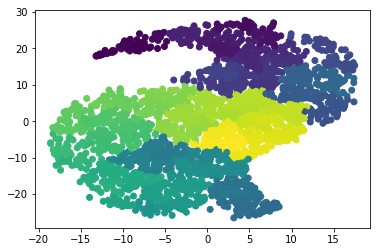

In [35]:
plt.scatter(nv_cm.T[0], nv_cm.T[1], c=clusters)

In [2]:
import ncvis

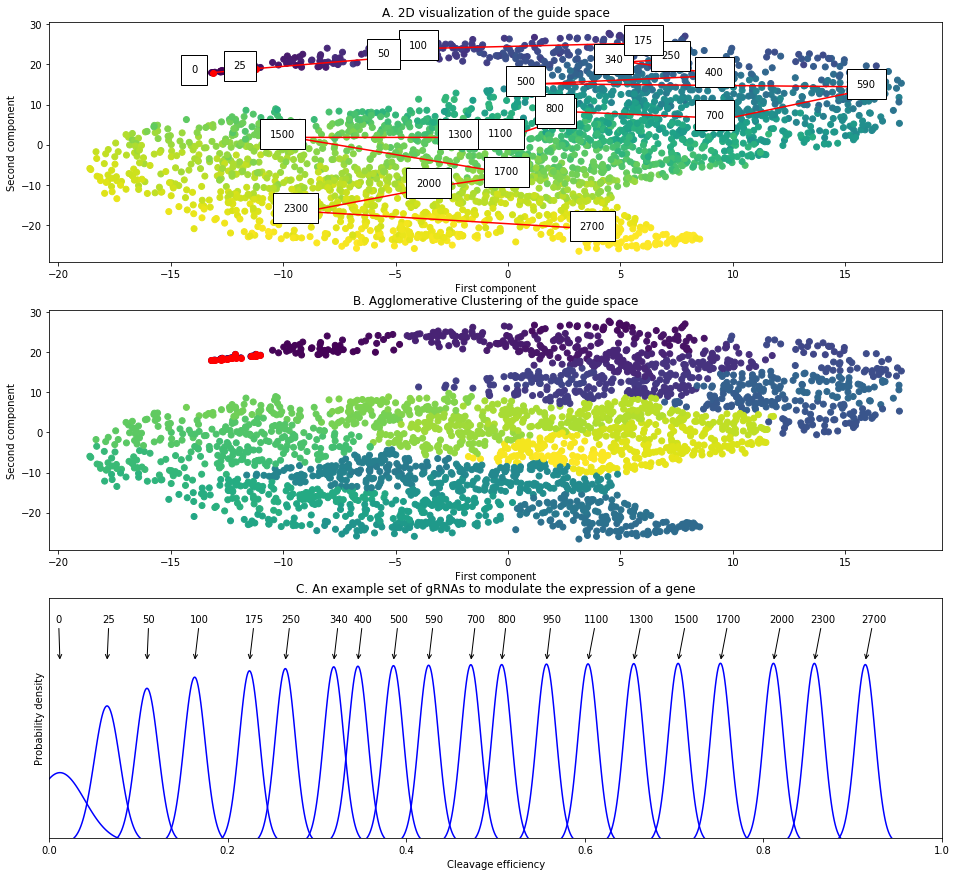

In [36]:
from matplotlib import rcParams

rcParams["figure.figsize"] = (16, 15)
numbers = [
    0, 25, 50, 100, 175, 250, 340, 400, 500, 590, 700, 800, 950,
    1100, 1300, 1500, 1700, 2000, 2300, 2700
]
tb_cnn_mse_oa_o = np.array(sorted(tb_cnn_mse_oa))
tb_cnn_mse_va = np.array(tb_cnn_mse_va)
mus = [tb_cnn_mse_oa_o[a] for a in numbers]
sigmas = [tb_cnn_mse_va[tb_cnn_mse_oa == a] for a in mus]
Xs = [nv_cm.T[0][tb_cnn_mse_oa == a] for a in mus]
Ys = [nv_cm.T[1][tb_cnn_mse_oa == a] for a in mus]
top20 = np.arange(tb_cnn_mse_oa_o.shape[0])[clusters == 1]
Xs_top20 = [nv_cm.T[0][a] for a in top20]
Ys_top20 = [nv_cm.T[1][a] for a in top20]
plt.subplot(3, 1, 1)
plt.scatter(nv_cm.T[0], nv_cm.T[1], c=tb_cnn_mse_oa)
plt.scatter(Xs, Ys, color="red")
plt.plot(Xs, Ys, color="red")
plt.title("A. 2D visualization of the guide space")
for a,b,num in list(reversed(list(zip(Xs, Ys, numbers)))):
    plt.annotate(
        str(num), xy=(a-1,b), bbox={'facecolor': 'white', 'alpha': 1, 'pad': 10}
    )
plt.xlabel("First component")
plt.ylabel("Second component")
from scipy import stats
plt.subplot(3,1,2)
plt.scatter(nv_cm.T[0], nv_cm.T[1], c=clusters)
plt.scatter(Xs_top20, Ys_top20, color="red")
plt.title("B. Agglomerative Clustering of the guide space")
plt.xlabel("First component")
plt.ylabel("Second component")
plt.subplot(3,1,3)
for mu, sigma, num in zip(mus, sigmas, numbers):
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
    plt.plot(x, stats.norm.pdf(x, mu, sigma), color="blue")
    plt.annotate(
        str(num), xy=(mu,37), xytext=(mu-0.005, 45), 
        arrowprops=dict(facecolor='black', arrowstyle="->"),
    )
plt.xlim((0,1))
plt.ylim((1,50))
plt.yticks([])
plt.xlabel("Cleavage efficiency")
plt.ylabel("Probability density")
plt.title("C. An example set of gRNAs to modulate the expression of a gene")
plt.show()

In [37]:
from weblogolib import *

In [38]:
with open("test.fa", "w") as oh:
    for a in current_df.iloc[top20][3].values:
        oh.write(">\n"+a[:-2]+"\n")

In [39]:
fin = open("test.fa")
seqs = read_seq_data(fin)

In [40]:
logodata = LogoData.from_seqs(seqs)

In [41]:
logooptions = LogoOptions()
logooptions.title = "Most Active Cluster Logo"
logoformat = LogoFormat(logodata, logooptions)

In [42]:
png = png_formatter(logodata, logoformat)

In [43]:
with open("logo.png", "wb") as oh:
    oh.write(png)

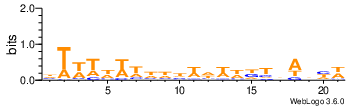

In [44]:
Image("logo.png")

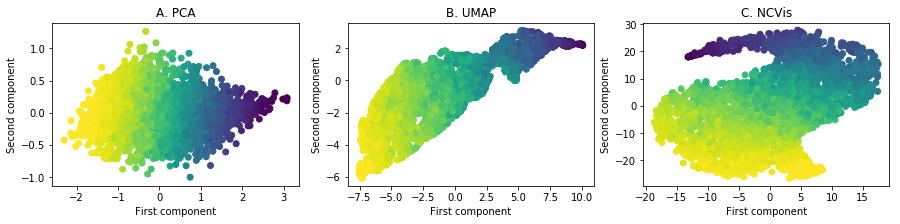

In [45]:
from matplotlib.patches import Patch
from matplotlib.pyplot import rcParams

rcParams["figure.figsize"] = (15, 3)
data1 = np.random.normal(size=100)
fig, ax = plt.subplots(nrows=1, ncols=3)
ax[0].scatter(pv_cm.T[0], pv_cm.T[1], c=tb_cnn_mse_oa)
ax[0].set_title("A. PCA")
ax[0].set_xlabel("First component")
ax[0].set_ylabel("Second component")
ax[1].scatter(uvis_cm.embedding_.T[0], uvis_cm.embedding_.T[1], c=tb_cnn_mse_oa)
ax[1].set_title("B. UMAP")
ax[1].set_xlabel("First component")
ax[1].set_ylabel("Second component")
ax[2].scatter(nv_cm.T[0], nv_cm.T[1], c=tb_cnn_mse_oa)
ax[2].set_title("C. NCVis")
ax[2].set_xlabel("First component")
ax[2].set_ylabel("Second component")
plt.show()

### All Logos

In [46]:
def logo(n=1, folder="logos"):
    if not op.exists(folder):
        os.makedirs(folder)
    top20 = np.arange(tb_cnn_mse_oa_o.shape[0])[clusters == n]
    with open("test.fa", "w") as oh:
        for a in current_df.iloc[top20][3].values:
            oh.write(">\n"+a[:-2]+"\n")
    fin = open("test.fa")
    seqs = read_seq_data(fin)
    logodata = LogoData.from_seqs(seqs)
    logooptions = LogoOptions()
    logooptions.title = "Most Active Cluster Logo"
    logoformat = LogoFormat(logodata, logooptions)
    png = png_formatter(logodata, logoformat)
    with open(op.join(folder, str(n)+".png"), "wb") as oh:
        oh.write(png)

In [47]:
np.unique(clusters).shape

(207,)

In [48]:
for a in tqdm(np.arange(np.unique(clusters).shape[0])):
    logo(a+1)

100%|██████████| 207/207 [00:46<00:00,  4.45it/s]


In [4]:
out_md = "out.md"

In [50]:
fs = [op.join("logos", a) for a in sorted(
    [a for a in os.walk("logos")][0][2], 
    key=lambda x: int(x.split(".")[0])
)]

In [51]:
with open(out_md, "w") as oh:
    for a in fs:
        oh.write(op.split(a)[-1].split(".")[0]+"\n")
        oh.write("![]("+a+")\n")